<a href="https://colab.research.google.com/github/vaibhav1111011/Face_Detector/blob/main/fish_disease_detection_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [56]:
train_datagen =ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [57]:
train=train_datagen.flow_from_directory(directory="/content/sample_data/train data",target_size=(256,256),batch_size=32)
val=val_datagen.flow_from_directory(directory="/content/sample_data/train data",target_size=(256,256),batch_size=32)

Found 102 images belonging to 7 classes.
Found 102 images belonging to 7 classes.


In [58]:
t_img,label=train.next()

In [59]:
def plotImage(img_arr,label):
  for im, l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.show()

In [60]:
plotImage(t_img[:3],label[:3])

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

building our model

In [61]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [62]:
base_model=VGG19(input_shape=(256,256,3),include_top=False)

In [63]:
for layer in base_model.layers:
  layer.trainable=False

In [64]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [65]:
X=Flatten()(base_model.output)
X=Dense(units=7,activation='softmax')(X)

#creating our model
model=Model(base_model.input,X)

In [66]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [67]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

#Early stopping and model check point



In [68]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

#early stopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
#model heck point
mc=ModelCheckpoint(filepath="best_model.h5",monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only=True)
cb=[es,mc]

In [84]:
his=model.fit_generator(train,steps_per_epoch=16,epochs=50,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
 4/16 [======>.......................] - ETA: 5s - loss: 10.5183 - accuracy: 0.7549WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 800 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy did not improve from 0.77451
16/16 [==============================] - 4s 185ms/step - loss: 10.5183 - accuracy: 0.7549 - val_loss: 13.8027 - val_accuracy: 0.7549


In [70]:
h=his.history
h.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

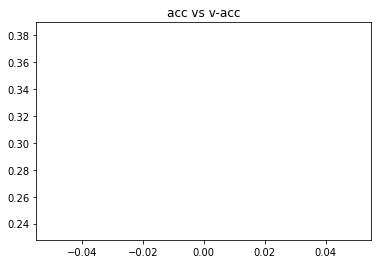

In [85]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c="red")
plt.title("acc vs v-acc")
plt.show()

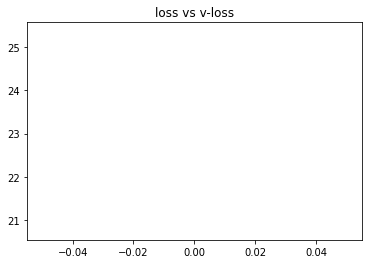

In [86]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c="red")
plt.title("loss vs v-loss")
plt.show()

In [87]:
#load best model
from keras.models import load_model
model=load_model("/content/best_model.h5")

In [74]:
acc=model.evaluate_generator(val)[1]
print(f"the accuracy of your model is={acc*100} %")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


the accuracy of your model is=38.235294818878174 %


In [100]:
ref=dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [101]:
def prediction(path):
  img=load_img(path,target_size=(256,256))
  i=img_to_array(img)
  im=preprocess_input(i)
  img=np.expand_dims(im,axis=0)
  pred=np.argmax(model.predict(img))
  print(f"the image belongs to{ref[pred]}")

In [108]:
path="/content/sample_data/train data/argulus (4).jpg"
prediction(path)

the image belongs toArgulus


In [98]:
train.class_indices

{'.ipynb_checkpoints': 0,
 'Argulus': 1,
 'Broken antennae and rostrum': 2,
 'EUS': 3,
 'Redspot': 4,
 'THE BACTERIAL GILL ROT': 5,
 'Tail And Fin Rot': 6}